In [2]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import f_oneway

c:\Users\Wyss User\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


2023-12-03 13:25:55,171 | INFO : Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-03 13:25:55,172 | INFO : NumExpr defaulting to 8 threads.


In [3]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
ENDOTHELIAL_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\endothelial_fasta.fasta"
)
FETAL_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\fetal_astrocyte_fasta.fasta"
)
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MANIFEST_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Shah (BWH)_OLINK_SK-5T4V_2023-06-27_MN UPDATES 82823.xlsx"
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = [
    "Fract 6 ",
    "Fract 7",
    "Fract 8",
    "Fract 9",
    "Fract 10",
    "Fract 11",
    "Fract 12",
    "Fract 13",
    "Fract 14",
    "Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

CSF_SAMPLES = [
    "Fract 6 ",
    "Fract 7",
    "Fract 8",
    "Fract 9",
    "Fract 10",
    "Fract 11",
    "Fract 12",
    "Fract 13",
    "Fract 14",
    "Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV"
]

In [4]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes

plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
manifest = pd.read_excel(MANIFEST_PATH, index_col=0)
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

raw_data["Location"] = raw_data["SampleID"].map(manifest["Broad_Sample_ID"])
for column in plate_layout.columns:
    raw_data[column] = raw_data["Location"].map(plate_layout[column])

raw_data["Linear NPX"] = raw_data["NPX"].map(lambda x: 2**x)

AMP2
0.0673260457072605
INC1
0.045278582916740584
INC2
0.05586571977867327
AMP1
0.07243477096410111
AMP3
0.037089009342001794
AMP4
0.029939346198654654
INC3
0.03780425928228348
INC4
0.04070946718715076
P14902
0.31916010920317095
P29536
0.19937108325347694
P10145
0.2855409573719119
P01375
0.31713046284653196
P05231
0.23188013186968637
Q14160
0.13090501274155825


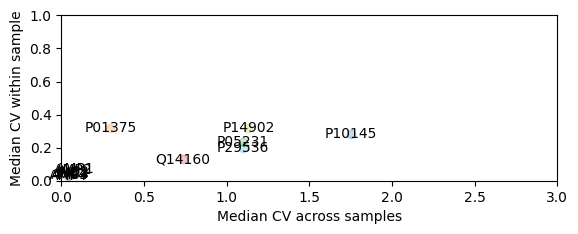

In [5]:
vc = raw_data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]
vc
# vc.value_counts()
# vc.index.get_level_values(2).value_counts()
repeated_markers = vc.index.get_level_values("UniProt").unique()

markers_in_multiple_panels = raw_data[
    raw_data["UniProt"].isin(repeated_markers) & (raw_data["Sample_Type"] == "SAMPLE")
].pivot(columns=["UniProt", "Panel"], index="SampleID", values="Linear NPX")
linear_lod = 2 ** (
    raw_data[
        raw_data["UniProt"].isin(repeated_markers)
        & (raw_data["Sample_Type"] == "SAMPLE")
    ].pivot(columns=["UniProt", "Panel"], index="SampleID", values="LOD")
)

markers_in_multiple_panels["P14902"].std(axis=1) / markers_in_multiple_panels[
    "P14902"
].mean(axis=1)

fig, ax = plt.subplots()
for marker in repeated_markers:
    df = markers_in_multiple_panels[
        markers_in_multiple_panels > linear_lod.fillna(-np.inf)
    ][marker]
    x = (df.std(axis=0) / df.mean(axis=0)).median()
    y = (df.std(axis=1) / df.mean(axis=1)).median()
    print(marker)
    print(y)
    ax.plot([x], [y], "o", alpha=0.25)
    ax.text(x, y, marker, horizontalalignment="center", verticalalignment="center")
ax.set(
    aspect="equal",
    xlim=(0, 3),
    ylim=(0, 1),
    xlabel="Median CV across samples",
    ylabel="Median CV within sample",
)

plt.show()

In [6]:
markers_in_multiple_panels[markers_in_multiple_panels > linear_lod.fillna(-np.inf)]

UniProt,INC1,AMP1,P01375,P05231,INC2,AMP2,P10145,INC3,AMP3,INC4,...,AMP1,INC2,AMP2,INC3,AMP3,P29536,INC4,AMP4,Q14160,P14902
Panel,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,Cardiometabolic,...,Oncology_II,Oncology_II,Oncology_II,Oncology_II,Oncology_II,Oncology_II,Oncology_II,Oncology_II,Oncology_II,Oncology_II
SampleID,,,,,,,,,,,,,,,,,,,,,
SM-N8JPG,1.074600,0.998545,1.374684,NaN,0.893847,0.878187,NaN,1.100913,1.015225,1.056286,...,0.818129,0.982616,0.872907,1.057971,1.020305,NaN,0.973802,0.946648,NaN,NaN
SM-N8JPH,1.058484,1.139025,1.014522,NaN,1.085982,1.068732,NaN,1.032756,0.997231,0.953827,...,1.022145,1.057384,1.006886,0.985891,1.043984,NaN,0.965535,0.990137,1.057678,1.082000
SM-N8JPI,0.933551,1.079902,0.846276,NaN,1.013397,1.023350,NaN,1.156688,0.966673,1.005282,...,1.021578,1.008213,1.057898,0.986233,0.997715,1.055115,1.018679,1.022996,1.197313,0.998199
SM-N8JPJ,0.983707,0.959131,0.815864,NaN,1.040228,1.059292,NaN,1.066512,1.038643,1.007374,...,1.001318,1.064665,1.141871,1.051683,1.036270,NaN,1.100684,1.005630,NaN,1.729074
SM-N8JPK,0.942981,0.978742,1.343317,NaN,1.054530,1.042610,NaN,1.028399,1.104582,0.989108,...,1.028470,1.079528,1.040589,0.970298,0.976032,NaN,0.994746,1.075196,NaN,1.534427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-N8JS1,0.991785,1.041022,1.566343,2.961648,1.074675,0.975896,1.306765,0.907268,1.022783,0.970971,...,1.040733,0.882764,0.963462,0.955482,1.091188,NaN,0.853285,1.002846,NaN,NaN
SM-N8JS2,1.054969,1.030683,1.100913,NaN,1.003055,1.047101,1.437937,0.926460,0.974409,0.854232,...,0.964933,0.911364,1.019598,0.997024,1.006956,NaN,0.910986,1.063706,NaN,1.623604


In [7]:
# # tidy_data = pd.DataFrame(index = raw_data["SampleID"].unique(), dtype = float)
# tidy_data = raw_data[raw_data["Sample_Type"] == "SAMPLE"].pivot(
#     columns="UniProt", index="SampleID", values="Linear NPX"
# )
# tidy_data

In [8]:
# Normalize the data by panel according to the plate controls
normalized_data = pd.DataFrame()

for panel in PANELS:
    df = raw_data[(raw_data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["Linear NPX"].median()
    df["Delta"] = df["Linear NPX"].apply(lambda x: x - plate_ctrl)
    inc_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL") & (df["Assay"] == "Incubation control 1")
    ]["Delta"].median()
    df["Delta Delta"] = df["Delta"].apply(lambda x: x - inc_ctrl)
    normalized_data = pd.concat([normalized_data, df], ignore_index=True)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18516\3210660536.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Delta"] = df["Linear NPX"].apply(lambda x: x - plate_ctrl)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18516\3210660536.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Delta Delta"] = df["Delta"].apply(lambda x: x - inc_ctrl)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18516\3210660536.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [27]:
# Anova test to determine significance of differences between healthy, mild cognitive impairment, and AD samples
assay_list = pd.read_excel(ASSAY_LIST_PATH)

anova_test = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list["UniProt ID"]:
    assay_df = normalized_data[normalized_data["UniProt"] == assay]
    healthy_df = assay_df[
        (assay_df["CSF_sample"] == "CSF1")
        | (assay_df["CSF_sample"] == "CSF2")
        | (assay_df["CSF_sample"] == "CSF3")
        | (assay_df["CSF_sample"] == "CSF4")
    ]
    moderate_impairment_df = assay_df[
        (assay_df["CSF_sample"] == "CSF5") | (assay_df["CSF_sample"] == "CSF8")
    ]
    ad_df = assay_df[
        (assay_df["CSF_sample"] == "CSF6") | (assay_df["CSF_sample"] == "CSF7")
    ]

    healthy_delta1 = healthy_df["Delta"].tolist()
    healthy_delta2 = [x for x in healthy_delta1 if not math.isnan(x)]
    healthy_delta = [int(x) for x in healthy_delta2]

    moderate_delta1 = moderate_impairment_df["Delta"].tolist()
    moderate_delta2 = [x for x in moderate_delta1 if not math.isnan(x)]
    moderate_delta = [int(x) for x in moderate_delta2]

    ad_delta1 = ad_df["Delta"].tolist()
    ad_delta2 = [x for x in ad_delta1 if not math.isnan(x)]
    ad_delta = [int(x) for x in ad_delta2]

    statistic, p_value = f_oneway(healthy_delta2, moderate_delta2, ad_delta2)
    result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [p_value], "Statistic": [statistic]}
    )
    anova_test = pd.concat([anova_test, result_row], ignore_index=True)

print(anova_test["p-value"].mean())
print(anova_test["p-value"].median())
sig_results = anova_test[anova_test["p-value"] < 0.05]
# sig_results.to_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\sig_results_anova.xlsx")

c:\Users\Wyss User\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


0.48244733511005455
0.49877873203673584


In [47]:
sig_results

,Assay,p-value,Statistic
7,Q969D9,3.643669e-02,3.458829
106,P41218,1.226084e-07,19.707599
109,P16112,4.745406e-02,3.171894
113,O75340,1.205963e-02,4.681350
145,P35754,7.345438e-03,5.241014
...,...,...,...
2903,Q8N6M0,5.507512e-03,5.569407
2919,Q14011,1.801275e-02,4.233684
2926,Q9UMS0,2.864858e-02,3.721725
2936,Q9H910,1.381970e-02,4.528823


In [76]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# output_columns = ["Assay", "group1", "group2", "meandiff", "p-adj", "lower", "upper", "reject"]
tk_output = pd.DataFrame()

for assay in sig_results["Assay"]:   
    assay_df = normalized_data[normalized_data["UniProt"] == assay]
    healthy_df = assay_df[
        (assay_df["CSF_sample"] == "CSF1")
        | (assay_df["CSF_sample"] == "CSF2")
        | (assay_df["CSF_sample"] == "CSF3")
        | (assay_df["CSF_sample"] == "CSF4")
    ]
    moderate_impairment_df = assay_df[
        (assay_df["CSF_sample"] == "CSF5") | (assay_df["CSF_sample"] == "CSF8")
    ]
    ad_df = assay_df[
        (assay_df["CSF_sample"] == "CSF6") | (assay_df["CSF_sample"] == "CSF7")
    ]  
    healthy_delta1 = healthy_df["Delta"].tolist()
    healthy_delta2 = [x for x in healthy_delta1 if not math.isnan(x)]
    moderate_delta1 = moderate_impairment_df["Delta"].tolist()
    moderate_delta2 = [x for x in moderate_delta1 if not math.isnan(x)]
    ad_delta1 = ad_df["Delta"].tolist()
    ad_delta2 = [x for x in ad_delta1 if not math.isnan(x)]
    tk_input = pd.DataFrame({
        "values": healthy_delta2 + moderate_delta2 + ad_delta2,
        "group": ["Healthy Samples"]*len(healthy_delta2) + ["MCI Samples"]*len(moderate_delta2) + ["AD Samples"]*len(ad_delta2)
    })
    tukey_results = pairwise_tukeyhsd(tk_input["values"], tk_input["group"])
    tukey_df = pd.DataFrame(tukey_results.summary(), columns=tukey_results.data[0].dtype.names)
    tukey_df["Assay"] = assay
    tk_output = pd.concat([tk_output, tukey_df], axis=0)


In [43]:
tk_numeric = pd.to_numeric(tk_input["values"], errors = "coerce")


In [87]:
tk_output = tk_output.rename(columns={0: "Group 1", 1: "Group 2", 2: "Mean Difference", 3: "Adjusted p-value", 4: "Lower", 5: "Upper", 6: "Reject?", "Assay": "Assay"})

In [107]:
tk_output.drop(tk_output[tk_output["Group 1"].str.strip() == "group1"].index, inplace=True)
tk_output.drop(tk_output[tk_output["Group 1"] == "group1"].index, inplace=True)


In [46]:
print(tukey_results)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
     AD Samples Healthy Samples   0.0655 0.9614 -0.5198 0.6508  False
     AD Samples     MCI Samples  -0.4197 0.3042 -1.0955 0.2562  False
Healthy Samples     MCI Samples  -0.4852 0.1238 -1.0705 0.1001  False
---------------------------------------------------------------------


In [10]:
# Tukey-Kramer test-- post hoc analysis of anova results to correct for differences
from scipy.stats import tukey_hsd
output = stats.tukey_hsd(healthy_delta, moderate_delta, ad_delta)

In [13]:
from scipy.stats import tukey_hsd

# Assuming healthy_delta, moderate_delta, and ad_delta are your data arrays
# Make sure they are in the correct format for tukey_hsd

data = [healthy_delta, moderate_delta, ad_delta]
labels = ['Healthy', 'MCI', 'AD']

# Run Tukey-Kramer test
result = tukey_hsd(data, labels)

# Access the summary of the test
print(result.summary())

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\276797431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd63["Sample"] = pd.Categorical(cd63["Sample"], categories=X_AXIS_ORDER, ordered=True)


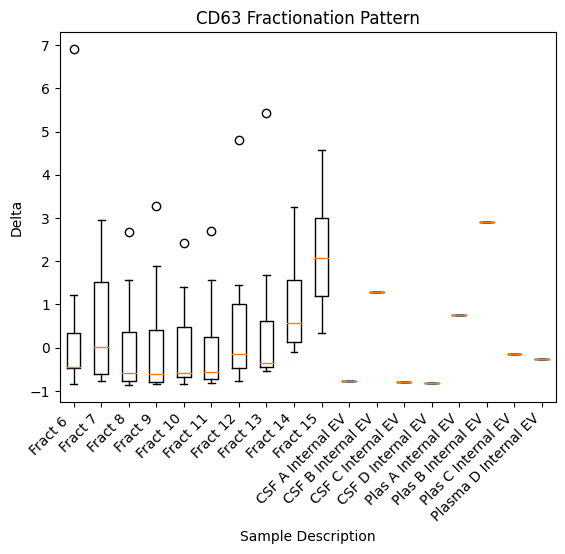

In [102]:
# Graph CD63 medians to confirm correct fractionation pattern
cd63 = normalized_data[normalized_data["Assay"] == "CD63"]
cd63["Sample"] = pd.Categorical(cd63["Sample"], categories=X_AXIS_ORDER, ordered=True)
cd63_sorted = cd63.sort_values("Sample")
grouped_data = [group["Delta"].values for name, group in cd63_sorted.groupby("Sample")]

plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)
plt.xlabel("Sample Description")
plt.ylabel("Delta")
plt.title("CD63 Fractionation Pattern")
plt.xticks(range(1, len(X_AXIS_ORDER) + 1), X_AXIS_ORDER)
plt.xticks(rotation=45, ha="right")
plt.show()

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\3476848694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)


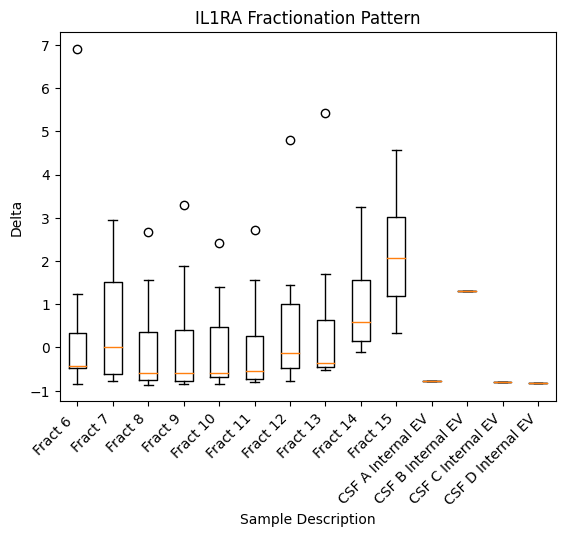

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\3476848694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)


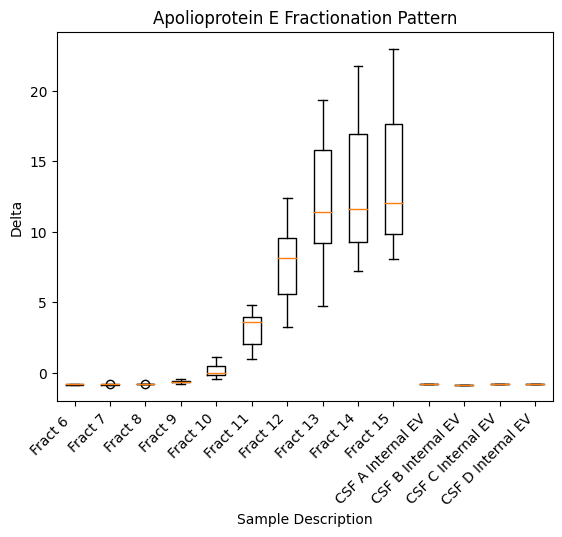

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\3476848694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)


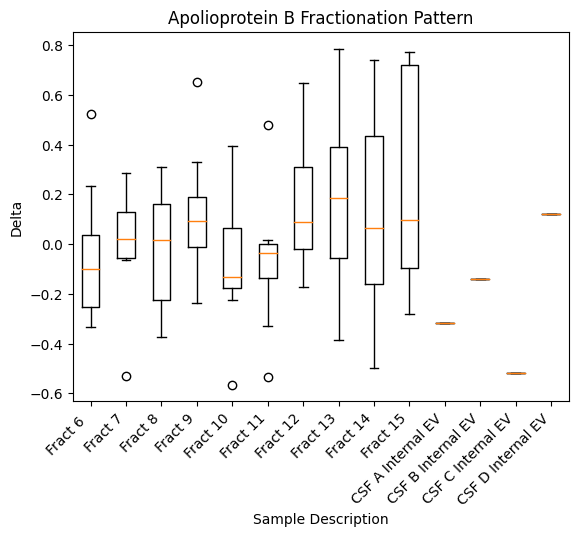

In [99]:
# Graph some secreted protein medians

def graph_medians(target, uniprot_id):
    df = normalized_data[normalized_data["UniProt"] == uniprot_id]
    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)
    df_sorted = df.sort_values("Sample")
    grouped_data = [group["Delta"].values for name, group in df_sorted.groupby("Sample")]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)
    plt.xlabel("Sample Description")
    plt.ylabel("Delta")
    plt.title(f"{target} Fractionation Pattern")
    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)
    plt.xticks(rotation=45, ha="right")
    plt.show()

graph_medians("IL1RA", "P18510")
graph_medians("Apolioprotein E", "P02649")
graph_medians("Apolioprotein B", "P04114")

In [ ]:
# TODO: see how many transmembrane/soluble/cytosolic proteins there are in the dataset and make a pie chart

In [68]:
# # Plot number of normalized NPX values above LOD by panel
# filtered_npx = normalized_data[normalized_data["Delta Delta"] > normalized_data["LOD"]]
# filtered_npx = filtered_npx[filtered_npx["QC_Warning"] == "PASS"]
# filtered_npx = filtered_npx[filtered_npx["Assay_Warning"] == "PASS"]


# def plot_by_panel(panel):
#     if panel in PANELS:
#         npx = filtered_npx[filtered_npx["Panel"] == panel]
#         counts = (npx["Sample"].value_counts()).reindex(X_AXIS_ORDER)
#         plt.bar(counts.index, counts.values, color="k", alpha=0.75)
#         plt.xlabel("Fraction")
#         plt.ylabel("Number of Passed Assays with Delta Delta > LOD")
#         plt.title(f"{panel} Panel Proteins by Fraction")
#         plt.xticks(rotation=45, ha="right")
#         plt.show()
#     else:
#         fract_counts = (filtered_npx["Sample"].value_counts()).reindex(X_AXIS_ORDER)
#         plt.bar(fract_counts.index, fract_counts.values, color="k", alpha=0.75)
#         plt.xlabel("Fraction")
#         plt.ylabel("Number of Assays with Delta Delta > LOD")
#         plt.title("All Panels Passed Assays by Fraction")
#         plt.xticks(rotation=45, ha="right")
#         plt.show()


# plot_by_panel("all")
# for panel in PANELS:
#     plot_by_panel(panel)

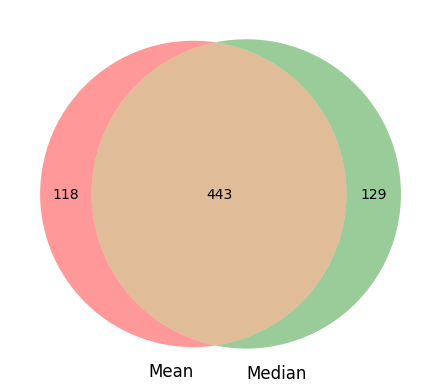

In [ ]:
# Identify targets with the correct fraction pattern
def filter_fractions(subset, fraction_labels):
    subset = subset.dropna(subset=["Sample"])
    return subset[subset["Sample"].str.contains("|".join(fraction_labels))]


def check_conditions(data, assay):
    late_ev_fractions = filter_fractions(data, ["Fract 9", "Fract 10"])
    all_ev_fractions = filter_fractions(
        data, ["Fract 7", "Fract 8", "Fract 9", "Fract 10"]
    )
    early_soluble_fractions = filter_fractions(data, ["Fract 11", "Fract 12"])
    late_soluble_fractions = filter_fractions(data, ["Fract 13", "Fract 14"])

    mean_condition = (
        (late_ev_fractions["Delta"].mean() > early_soluble_fractions["Delta"].mean())
        and (all_ev_fractions["Delta"].mean() > late_soluble_fractions["Delta"].mean())
    ) or (
        (all_ev_fractions["Delta"].mean() > early_soluble_fractions["Delta"].mean())
        and (late_ev_fractions["Delta"].mean() > late_soluble_fractions["Delta"].mean())
    )

    median_condition = (
        (
            late_ev_fractions["Delta"].median()
            > early_soluble_fractions["Delta"].median()
        )
        and (
            all_ev_fractions["Delta"].median()
            > late_soluble_fractions["Delta"].median()
        )
    ) or (
        (all_ev_fractions["Delta"].median() > early_soluble_fractions["Delta"].median())
        and (
            late_ev_fractions["Delta"].median()
            > late_soluble_fractions["Delta"].median()
        )
    )

    return assay if mean_condition else None, assay if median_condition else None


assay_list = pd.DataFrame({"UniProt ID": normalized_data["UniProt"].unique()})

correct_fractionation_mean = [
    assay
    for assay in assay_list["UniProt ID"].unique()
    if check_conditions(normalized_data[normalized_data["UniProt"] == assay], assay)[0]
    is not None
]
correct_fractionation_median = [
    assay
    for assay in assay_list["UniProt ID"].unique()
    if check_conditions(normalized_data[normalized_data["UniProt"] == assay], assay)[1]
    is not None
]

venn2(
    [set(correct_fractionation_mean), set(correct_fractionation_median)],
    set_labels=("Mean", "Median"),
)
plt.show()

In [ ]:
def calculate_means_and_merge(cell_type_df, not_mean_calc):
    values = cell_type_df.drop(not_mean_calc, axis=1)
    values["Mean"] = values.apply(lambda row: row.mean(), axis=1)
    means = pd.merge(cell_type_df, values["Mean"], left_index=True, right_index=True)
    return means


def filter_targets(cell_type_means, other_means, threshold):
    return cell_type_means[cell_type_means["Mean"] > (threshold * other_means["Mean"])]


def process_cell_type(brain_rna_seq, cell_type_cols, not_mean_calc, threshold):
    cell_type_df = brain_rna_seq[cell_type_cols]
    cell_type_means = calculate_means_and_merge(cell_type_df, not_mean_calc)

    for other_cell_type_cols in [
        c
        for c in [
            mature_astrocytes_cols,
            fetal_astrocytes_cols,
            endothelial_cols,
            microglia_cols,
            oligodendrocyte_cols,
        ]
        if c != cell_type_cols
    ]:
        other_means = calculate_means_and_merge(
            brain_rna_seq[other_cell_type_cols], not_mean_calc
        )
        cell_type_targets = filter_targets(cell_type_means, other_means, threshold)
        cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
            " - ", expand=True
        )
        return cell_type_targets


# Read the brain RNA-seq data
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

# Define columns for each cell type
fetal_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_fetal_1",
    "astrocytes_fetal_2",
    "astrocytes_fetal_3",
    "astrocytes_fetal_4",
    "astrocytes_fetal_5",
    "astrocytes_fetal_6",
]
mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
endothelial_cols = ["gene_id", "id", "endothelial_1", "endothelial_2"]
microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
not_mean_calc = ["gene_id", "id"]

# Define the threshold for 3x enrichment
cell_type_enrichment_threshold = 3

# Process each cell type
fetal_astrocyte_targets = process_cell_type(
    brain_rna_seq, fetal_astrocytes_cols, not_mean_calc, cell_type_enrichment_threshold
)
mature_astrocyte_targets = process_cell_type(
    brain_rna_seq, mature_astrocytes_cols, not_mean_calc, cell_type_enrichment_threshold
)
endothelial_targets = process_cell_type(
    brain_rna_seq, endothelial_cols, not_mean_calc, cell_type_enrichment_threshold
)
microglia_targets = process_cell_type(
    brain_rna_seq, microglia_cols, not_mean_calc, cell_type_enrichment_threshold
)
oligodendrocyte_targets = process_cell_type(
    brain_rna_seq, oligodendrocyte_cols, not_mean_calc, cell_type_enrichment_threshold
)

# map the hgnc id's to the uniprot id's

response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t")


def uniprot_and_fractionation(df):
    df = pd.merge(
        df,
        uniprot_ids[["hgnc_id", "uniprot_ids"]],
        left_on="id",
        right_on="hgnc_id",
        how="left",
    )
    return df[df["uniprot_ids"].isin(correct_fractionation_median)]


fetal_astrocyte_targets = uniprot_and_fractionation(fetal_astrocyte_targets)
mature_astrocyte_targets = uniprot_and_fractionation(mature_astrocyte_targets)
endothelial_targets = uniprot_and_fractionation(endothelial_targets)
microglia_targets = uniprot_and_fractionation(microglia_targets)
oligodendrocyte_targets = uniprot_and_fractionation(oligodendrocyte_targets)

# microglia_targets = pd.merge(
#     microglia_targets,
#     uniprot_ids[["hgnc_id", "uniprot_ids"]],
#     left_on="id",
#     right_on="hgnc_id",
#     how="left",
# )

# microglia_targets = microglia_targets[
#     microglia_targets["uniprot_ids"].isin(correct_fractionation_median)
# ]

# # Overlay with correct_fractionation_median list
# def find_correct_fractionation(df):
#     return df[df[]]

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\2147801752.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\2147801752.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14424\2147801752.py:29: SettingWithCopyWarning: 
A value is trying

In [ ]:
fetal_astrocyte_targets

,gene_id,id,astrocytes_fetal_1,astrocytes_fetal_2,astrocytes_fetal_3,astrocytes_fetal_4,astrocytes_fetal_5,astrocytes_fetal_6,Mean,Gene,Species,hgnc_id,uniprot_ids
26,ACTN4 - Homo sapiens,HGNC:166,21.387800,9.88660,5.523150,12.16560,20.44930,3.79278,12.200872,ACTN4,Homo sapiens,HGNC:166,O43707
40,ADH4 - Homo sapiens,HGNC:252,0.100000,0.10000,0.333942,0.10000,2.27354,0.10000,0.501247,ADH4,Homo sapiens,HGNC:252,P08319
55,AGBL2 - Homo sapiens,HGNC:26296,0.656856,0.10000,0.203748,2.44771,0.10000,1.04916,0.759579,AGBL2,Homo sapiens,HGNC:26296,Q5U5Z8
71,AKT2 - Homo sapiens,HGNC:392,7.885300,7.87285,4.478680,6.68022,8.71227,2.14820,6.296253,AKT2,Homo sapiens,HGNC:392,P31751
115,ANXA2 - Homo sapiens,HGNC:537,9.768760,4.61138,6.983280,20.30810,0.10000,13.43470,9.201037,ANXA2,Homo sapiens,HGNC:537,P07355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,TIGIT - Homo sapiens,HGNC:26838,0.803846,1.11945,2.106410,1.50083,1.46016,3.85893,1.808271,TIGIT,Homo sapiens,HGNC:26838,Q495A1
3235,TNFAIP8 - Homo sapiens,HGNC:17260,0.100000,1.75872,0.027987,0.10000,0.10000,0.10000,0.364451,TNFAIP8,Homo sapiens,HGNC:17260,O95379
3238,TNFRSF12A - Homo sapiens,HGNC:18152,2.619880,11.36160,0.359231,5.01992,0.10000,4.28993,3.958427,TNFRSF12A,Homo sapiens,HGNC:18152,Q9NP84
3278,TRIM58 - Homo sapiens,HGNC:24150,0.450737,0.10000,0.699323,1.67478,0.10000,0.10000,0.520807,TRIM58,Homo sapiens,HGNC:24150,Q8NG06


In [1]:
# map the hgnc id's to the uniprot id's

# response = requests.get(HGNC_IDS)
# content = response.text

# file_like_object = StringIO(content)

# uniprot_ids = pd.read_csv(file_like_object, sep="\t")

# microglia_targets = pd.merge(
#     microglia_targets,
#     uniprot_ids[["hgnc_id", "uniprot_ids"]],
#     left_on="id",
#     right_on="hgnc_id",
#     how="left",
# )

# microglia_targets = microglia_targets[
#     microglia_targets["uniprot_ids"].isin(correct_fractionation_median)
# ]


# map uniprot id's to fasta
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""

    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence

    return protein_dict


protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

fetal_astrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)
mature_astrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)
endothelial_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)
microglia_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)
oligodendrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

# fetal_astrocyte_targets = fetal_astrocyte_targets.drop(fetal_astrocytes_cols, axis = 1)
# mature_astrocyte_targets = mature_astrocyte_targets.drop(mature_astrocytes_cols, axis = 1)
# endothelial_targets = endothelial_targets.drop(endothelial_cols, axis = 1)
# microglia_targets = microglia_targets.drop(microglia_cols, axis=1)
# oligodendrocyte_targets = oligodendrocyte_targets.drop(oligodendrocyte_cols, axis = 1)


# export the list of proteins in fasta format to be input into the online program
# link to program: https://dtu.biolib.com/DeepTMHMM
def export_fasta(output_path, df):
    with open(output_path, "w") as output_file:
        for index, row in df.iterrows():
            output_file.write(f'>{row["uniprot_ids"]}\n')
            output_file.write(f'{row["Sequence"]}\n')


export_fasta(FETAL_ASTROCYTE_FASTA_OUTPUT_PATH, fetal_astrocyte_targets)
export_fasta(MATURE_ASTROCYTE_FASTA_OUTPUT_PATH, mature_astrocyte_targets)
export_fasta(ENDOTHELIAL_FASTA_OUTPUT_PATH, endothelial_targets)
export_fasta(MICROGLIA_FASTA_OUTPUT_PATH, microglia_targets)
export_fasta(OLIGODENDROCYTE_FASTA_OUTPUT_PATH, oligodendrocyte_targets)

NameError: name 'UNIPROT_TO_FASTA_PATH' is not defined

In [ ]:
microglia_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_microglia"
)
endothelial_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_endothelial"
)
oligodendrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_oligodendrocyte"
)
fetal_astrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_fetal_astrocytes"
)
mature_astrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_mature_astrocytes"
)

deeptmhmm = biolib.load("DTU/DeepTMHMM")


def tmhmm_localization(targets, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    os.chdir(output_directory)
    for _, row in targets.iterrows():
        sequence = targets["Sequence"]
        # print(sequence)
        uniprot_id = targets["uniprot_ids"]
        # print(uniprot_id)
        # !echo -e f">{uniprot_id}\n{sequence}\n" > query.fasta
        fasta_line = f">{uniprot_id}\n{sequence}\n"
        with open("query.fasta", "w") as fasta_file:
            fasta_file.write(fasta_line)
        # deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta")
        # print(deeptmhmm_job)
        # deeptmhmm_job.save_files(output_directory)
        # Image(filename="plot.png")
        biolib.utils.STREAM_STDOUT = True  # Stream progress from app in real time
        deeptmhmm_job = deeptmhmm.cli(
            args="--fasta query.fasta", machine="local"
        )  # Blocks until done
        deeptmhmm_job.save_files(output_directory)  # Saves all results to `result` dir


tmhmm_localization(microglia_targets, microglia_output_directory)
tmhmm_localization(endothelial_targets, endothelial_output_directory)
tmhmm_localization(oligodendrocyte_targets, oligodendrocyte_output_directory)
tmhmm_localization(fetal_astrocyte_targets, fetal_astrocyte_output_directory)
tmhmm_localization(mature_astrocyte_targets, mature_astrocyte_output_directory)

2023-11-30 23:59:08,849 | INFO : Loaded project DTU/DeepTMHMM:1.0.24
>14      P33121
67      P07355
82      P62330
90      Q7Z6I6
114     P18848
147     Q9UBW5
167     Q9NQ88
228     P49662
253     P80098
273     Q9Y5K6
311     P49715
312     P17676
339     Q05315
369     P39059
400     P48061
418     O43739
422     P98082
463     Q99704
494     Q9NZJ5
520     P07992
582     O00602
587     Q9NP95
589     P09769
654     Q8ND71
720     Q9UKV0
744     P52789
803     Q13651
817     Q8IU57
818     P31785
839     P20701
1037    Q32MZ4
1109    P41218
1129    P13995
1131    O43312
1137    P35579
1145    Q13459
1169    Q14511
1195    P06748
1270    Q9UHV9
1272    Q96G03
1297    Q00722
1357    P18031
1380    Q9UKM9
1381    P49792
1382    P62834
1398    P50749
1411    Q9H6H4
1421    O43665
1454    O75695
1461    P50914
1512    Q9Y6U3
1592    O94813
1650    Q13277
1651    Q12846
1739    Q03169
1741    O95379
1742    Q6P589
1748    Q9NP84
1774    Q8NG06
1810    P32241
Name: uniprot_ids, dtype: obje

In [ ]:
# output_directory = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm1_microglia"

# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# os.chdir(output_directory)

# deeptmhmm = biolib.load("DTU/DeepTMHMM")

# for (
#     _,
#     row,
# ) in (
#     microglia_targets.iterrows()
# ):  # there has got to be a way to make this faster this is insanely slow
#     sequence = row["Sequence"]
#     print(sequence)
#     uniprot_id = row["uniprot_ids"]
#     print(uniprot_id)
#     # !echo -e f">{uniprot_id}\n{sequence}\n" > query.fasta
#     fasta_line = f">{uniprot_id}\n{sequence}\n"
#     with open("query.fasta", "w") as fasta_file:
#         fasta_file.write(fasta_line)
#     deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta")
#     print(deeptmhmm_job)
#     deeptmhmm_job.save_files(output_directory)
#     Image(filename="plot.png")
# is there a way to import all the files from the directory for bulk analysis?
# I think with each iteration of the loop it's incorrectly trying to change the name of the output file to add to the directory, making an inaccessible output file
# program (should) output an image of the plot (.png), and gff3/3line/md/csv files

In [ ]:
# make a list of the areas in which each target is localized
paths = [
    file.path
    for file in os.scandir(microglia_output_directory)
    if file.name.endswith(".csv")
]

target_loc = {}

for item in paths:
    df = pd.read_csv(item)
    id = df.columns[0]
    df = df.reset_index(drop=False)
    df.columns = df.iloc[0]
    df = df[1:]
    df[["#", "AA"]] = df["#AA"].str.split(expand=True)
    df = df.drop("#AA", axis=1)

    columns_list = ["Beta", "Periplasm", "Membrane", "Inside", "Outside", "Signal"]
    signal_columns = []
    for column in columns_list:
        selected_column = df[column]
        all_zero = all(value == "0.0" for value in selected_column)
        if all_zero is False:
            signal_columns.append(column)
    target_loc[id] = signal_columns

ParserError: Error tokenizing data. C error: Expected 7 fields in line 577, saw 8


In [ ]:
target_loc

{}

In [ ]:
# TODO: re-write the program to be run in the opposite order to make sure the output is the same (do transmembrane, then brain rna seq, and then fractionation pattern instead of the other way around)